# 第8章: ニューラルネット
第7章で取り組んだポジネガ分類を題材として、ニューラルネットワークで分類モデルを実装する。なお、この章ではPyTorchやTensorFlow、JAXなどの深層学習フレームワークを活用せよ。

## 70. 単語埋め込みの読み込み

事前学習済み単語埋め込みを活用し、$|V| \times d_{\mathrm{emb}}$ の単語埋め込み行列$\mathbf{E}$を作成せよ。ここで、$|V|$は単語埋め込みの語彙数、$d_{\mathrm{emb}}$は単語埋め込みの次元数である。ただし、単語埋め込み行列の先頭の行ベクトル$\mathbf{E}_{0,:}$は、将来的にパディング（`<PAD>`）トークンの埋め込みベクトルとして用いたいので、ゼロベクトルとして予約せよ。ゆえに、$\mathbf{E}$の2行目以降に事前学習済み単語埋め込みを読み込むことになる。

もし、Google Newsデータセットの[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)（300万単語・フレーズ、300次元）を全て読み込んだ場合、$|V|=3000001, d_{\mathrm{emb}}=300$になるはずである（ただ、300万単語の中には、殆ど用いられない稀な単語も含まれるので、語彙を削減した方がメモリの節約になる）。

また、単語埋め込み行列の構築と同時に、単語埋め込み行列の各行のインデックス番号（トークンID）と、単語（トークン）への双方向の対応付けを保持せよ。


In [135]:
import torch
import numpy as np
from gensim.models import KeyedVectors

# Load Word2Vec model
path = 'GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(path, binary=True)

emb_dim = w2v.vector_size   # Set embedding size: 300
vocab_size = len(w2v.key_to_index) + 1  # Add `<PAD>`

# Initialize the embedding matrix
E = np.zeros((vocab_size, emb_dim), dtype=np.float32)
token2id = {'<PAD>': 0}
id2token = {0: '<PAD>'}

# Fulfill the embedding matrix
for word, idx in w2v.key_to_index.items():
    token_id = idx + 1
    E[token_id] = w2v[word]     # Match the `token_id` and the corresponding word vector
    token2id[word] = token_id
    id2token[token_id] = word

# Convert embedding matrix to tensor
E_tensor = torch.Tensor(E)

# Verify
print(f"Shape of the embedding matrix: {E_tensor.size()}")       # (3000001, 300)
print(f"token2id {list(token2id.items())[:5]}:")
print(f"id2token: {list(id2token.items())[:5]}")

Shape of the embedding matrix: torch.Size([3000001, 300])
token2id [('<PAD>', 0), ('</s>', 1), ('in', 2), ('for', 3), ('that', 4)]:
id2token: [(0, '<PAD>'), (1, '</s>'), (2, 'in'), (3, 'for'), (4, 'that')]


## 71. データセットの読み込み
General Language Understanding Evaluation (GLUE) ベンチマークで配布されているStanford Sentiment Treebank (SST) をダウンロードし、訓練セット（train.tsv）と開発セット（dev.tsv）のテキストと極性ラベルと読み込み、全てのテキストをトークンID列に変換せよ。このとき、単語埋め込みの語彙でカバーされていない単語は無視し、トークン列に含めないことにせよ。また、テキストの全トークンが単語埋め込みの語彙に含まれておらず、空のトークン列となってしまう事例は、訓練セットおよび開発セットから削除せよ（このため、第7章の実験で得られた正解率と比較できなくなることに注意せよ）。

事例の表現方法は任意でよいが、例えば”contains no wit , only labored gags”がネガティブに分類される事例は、次のような辞書オブジェクトで表現すればよい。

<div style="border:1px solid #ccc; padding:10px; background-color:#f9f9f9; font-family:monospace;">
{'text': 'contains no wit , only labored gags',
 'label': tensor([0.]),
 'input_ids': tensor([ 3475,    87, 15888,    90, 27695, 42637])}
</div>

この例では、`text`はテキスト、`label`は分類ラベル（ポジティブなら`tensor([1.])`、ネガティブなら`tensor([0.])`）、`input_ids`はテキストのトークン列をID列で表現している。

In [128]:
import pandas as pd
import torch

def encode_sst(path_tsv: str, token2id: dict):
    df = pd.read_csv(path_tsv, sep='\t', usecols=['sentence', 'label'])
    examples = []
    # Iterate over each row
    for _, row in df.iterrows():
        text = row['sentence']
        label = torch.tensor([int(row['label'])], dtype=torch.float32)
        # Tokenize
        words = text.strip().split()
        ids = torch.tensor([token2id[word] for word in words if word in token2id], dtype=torch.long)
        # If the exmaple is empty, skip it
        if len(ids) == 0:
            continue
        examples.append({
            'text': text,
            'label': label,
            'input_ids': ids
        })
    return examples

train_data = encode_sst('train.tsv', token2id)
valid_data = encode_sst('dev.tsv', token2id)

print(f"Number of training data: {len(train_data)}")
print(f"Number of validation data: {len(valid_data)}")
for e in train_data[0].items():
    print(e)


Number of training data: 66650
Number of validation data: 872
('text', 'hide new secretions from the parental units ')
('label', tensor([0.]))
('input_ids', tensor([  5785,     66, 113845,     18,     12,  15095,   1594]))


## 72. Bag of wordsモデルの構築
単語埋め込みの平均ベクトルでテキストの特徴ベクトルを表現し、重みベクトルとの内積でポジティブ及びネガティブを分類するニューラルネットワーク（ロジスティック回帰モデル）を設計せよ。

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    def __init__(self, embed_matrix: torch.Tensor):
        '''
        embed_matrix: torch.Tensor of shape (3000001, 300)
        '''
        super().__init__()
        # Obtain the embedding dimension: 300
        dim_emb = embed_matrix.size()[1]
        # Load the pretrained embedding layer and freeze it
        self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=True, padding_idx=0)
        # Output a logits
        self.fc = nn.Linear(dim_emb, 1)
    
    def forward(self, input_ids: torch.Tensor):
        '''
        input_ids: torch.Tensor of shape (batch_size, seq_len)
        '''
        # Obtain the embedding representation
        emb = self.embedding(input_ids)    # shape: (batch_size, seq_len, dim_emb)

        # Assign zero vector to the word vector of `<PAD>`
        mask = (input_ids != 0).unsqueeze(-1)   # shape: (batch_size, seq_len, 1)
        emb = emb * mask    # shape: (batch_size, seq_len, dim_emb)

        # Obtain average embedding representation
        sum_emb = emb.sum(dim=1)    # shape: (batch_size, dim_emb)
        lengths = mask.sum(dim=1).clamp(min=1)  # Obtain the length of each sentence, excluding `<PAD>`
        avg_emb = sum_emb / lengths   # shape: (batch_size, dim_emb)

        # Obtain the output (logits)
        logits = self.fc(avg_emb)    # shape: (batch_size, 1)
        return logits

## 73. モデルの学習
問題72で設計したモデルの重みベクトルを訓練セット上で学習せよ。ただし、学習中は単語埋め込み行列の値を固定せよ（単語埋め込み行列のファインチューニングは行わない）。また、学習時に損失値を表示するなど、学習の進捗状況をモニタリングできるようにせよ。

Epoch 5 training loss: 0.3763
Epoch 5 validation loss: 0.4569

Epoch 10 training loss: 0.3691
Epoch 10 validation loss: 0.4492

Epoch 15 training loss: 0.3674
Epoch 15 validation loss: 0.4536

Epoch 20 training loss: 0.3665
Epoch 20 validation loss: 0.4467

Epoch 25 training loss: 0.3662
Epoch 25 validation loss: 0.4471

Epoch 30 training loss: 0.3659
Epoch 30 validation loss: 0.4461



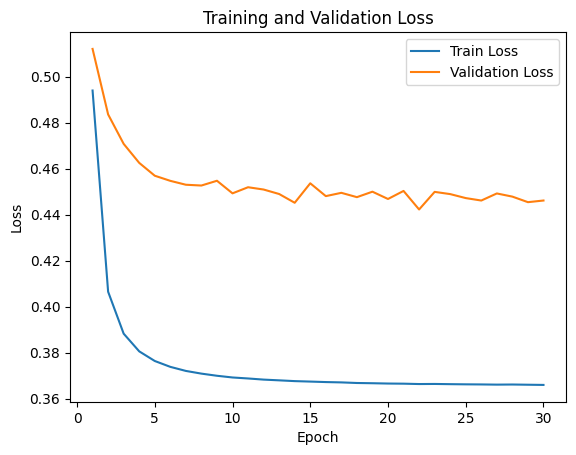

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# === 1. collate_fn ===
def collate_fn(batch):
    ids = [b['input_ids'] for b in batch]
    # Concatenate the label list into 
    labels = torch.cat([b['label'] for b in batch], dim=0)  # [tensor(0.), tensor(1.)] -> tensor([0., 1.]); shape: (batch, 1)
    # Padding based on sequence with the maximum length in the current batch
    padded_ids = pad_sequence(ids, batch_first=True, padding_value=0)  # (batch, L)
    return padded_ids, labels

# === 2. Load data ===
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# === 3. Set model, optimizer, and loss ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_73 = BoWClassifier(E_tensor).to(device)
optimizer = optim.Adam(model_73.parameters(), lr=1e-3)
loss_fn   = nn.BCEWithLogitsLoss()

# === 4. Training and Evaluation ===
def train(epoch, model, optimizer, loss_fn, train_dl):
    model.train()
    curr_total_loss = 0.0

    for input_ids, labels in train_dl:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device)  # (batch_size,)

        optimizer.zero_grad()
        logits = model(input_ids).squeeze(-1)   # (batch_size,)
        loss = loss_fn(logits, labels)  # (batch_size,)
        loss.backward()
        optimizer.step()

        curr_total_loss += loss.item()

    train_loss = curr_total_loss / len(train_dl)
    return train_loss

def eval(epoch, model, loss_fn, valid_dl):
    model.eval()
    curr_total_val_loss = 0.0
    
    with torch.no_grad():
        for input_ids, labels in valid_dl:
            input_ids = input_ids.to(device)    # (batch_size, L)
            labels = labels.to(device).squeeze(-1)  # (batch_size,)
            
            logits = model(input_ids).squeeze(-1)
            curr_total_val_loss += loss_fn(logits, labels).item()

        valid_loss = curr_total_val_loss / len(valid_dl)
    return valid_loss

epochs = 30
train_losses, valid_losses = [], []
valid_accs = []
for epoch in range(1, epochs + 1):
    train_losses.append(train(epoch, model_73, optimizer, loss_fn, train_loader))
    valid_losses.append(eval(epoch, model_73, loss_fn, valid_loader))
    if epoch % 5 == 0:
        print(f"Epoch {epoch} training loss: {train_losses[-1]:.4f}")
        print(f"Epoch {epoch} validation loss: {valid_losses[-1]:.4f}\n")

# === 5. Plot ===
x = list(range(1, len(train_losses) + 1))
plt.figure()
plt.plot(x, train_losses, label='Train Loss')
plt.plot(x, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 74. モデルの評価
問題73で学習したモデルの開発セットにおける正解率を求めよ。

In [104]:
model_73.eval()
curr_correct, total = 0, 0

with torch.no_grad():
    for input_ids, labels in valid_loader:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device).squeeze(-1)  # (batch_size,)
        
        logits = model_73(input_ids).squeeze(-1)

        preds = (torch.sigmoid(logits) > 0.5).long()
        curr_correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"validation loss: {valid_loss:.4f}, accuracy: {accuracy * 100:.2f}%")

    


validation loss: 0.4462, accuracy: 83.49%


## 75. パディング
複数の事例が与えられたとき、これらをまとめて一つのテンソル・オブジェクトで表現する関数`collate`を実装せよ。与えられた複数の事例のトークン列の長さが異なるときは、トークン列の長さが最も長いものに揃え、0番のトークンIDでパディングをせよ。さらに、トークン列の長さが長いものから順に、事例を並び替えよ。

例えば、訓練データセットの冒頭の4事例が次のように表されているとき、

<div style="border:1px solid #ccc;
            padding:10px;
            background-color:#f9f9f9;
            font-family:monospace;
            white-space: pre;">
[{'text': 'hide new secretions from the parental units',
  'label': tensor([0.]),
  'input_ids': tensor([  5785,     66, 113845,     18,     12,  15095,   1594])},
 {'text': 'contains no wit , only labored gags',
  'label': tensor([0.]),
  'input_ids': tensor([ 3475,    87, 15888,    90, 27695, 42637])},
 {'text': 'that loves its characters and communicates something rather beautiful about human nature',
  'label': tensor([1.]),
  'input_ids': tensor([    4,  5053,    45,  3305, 31647,   348,   904,  2815,    47,  1276,  1964])},
 {'text': 'remains utterly satisfied to remain the same throughout',
  'label': tensor([0.]),
  'input_ids': tensor([  987, 14528,  4941,   873,    12,   208,   898])}]
</div>


`collate`関数を通した結果は以下のようになることが想定される。

<div style="border:1px solid #ccc;
            padding:10px;
            background-color:#f9f9f9;
            font-family:monospace;">
  <pre style="margin:0;">
{'input_ids': tensor([
    [     4,   5053,     45,   3305,  31647,    348,    904,   2815,     47,   1276,   1964],
    [  5785,     66, 113845,     18,     12,  15095,   1594,      0,      0,      0,      0],
    [   987,  14528,   4941,    873,     12,    208,    898,      0,      0,      0,      0],
    [  3475,     87,  15888,     90,  27695,  42637,      0,      0,      0,      0,      0]
]),
 'label': tensor([
    [1.],
    [0.],
    [0.],
    [0.]
])
}
  </pre>
</div>


In [105]:
def collate_fn(batch):
    ids = [b['input_ids'] for b in batch]
    # Concatenate the label list into 
    labels = torch.cat([b['label'] for b in batch], dim=0)  # [tensor(0.), tensor(1.)] -> tensor([0., 1.]); shape: (batch, 1)
    # Padding based on sequence with the maximum length in the current batch
    padded_ids = pad_sequence(ids, batch_first=True, padding_value=0)  # (batch, L)
    return {
        'input_ids': padded_ids,
        'label': labels
    }

train_dl = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Print the result
print(next(iter(train_dl)))


{'input_ids': tensor([[   12,  3652,  1122,    25,    53,    12, 19163,  8072,   581,   245,
          6372,    49,   977,    51,  7403],
        [   16,  3808,  7688,    70,  6858,    12,   133,  3190,  3577,  3527,
          1416, 25426,     0,     0,     0],
        [12057,   338,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  138,    14,    17,   268,  1869, 21828,     0,     0,     0,     0,
             0,     0,     0,     0,     0]]), 'label': tensor([1., 1., 0., 0.])}


## 76. ミニバッチ学習
問題75のパディングの処理を活用して、ミニバッチでモデルを学習せよ。また、学習したモデルの開発セットにおける正解率を求めよ。

Epoch 5 training loss: 0.3763
Epoch 5 validation loss: 0.4611

Epoch 10 training loss: 0.3692
Epoch 10 validation loss: 0.4493

Epoch 15 training loss: 0.3673
Epoch 15 validation loss: 0.4506

Epoch 20 training loss: 0.3666
Epoch 20 validation loss: 0.4456

Epoch 25 training loss: 0.3662
Epoch 25 validation loss: 0.4484

Epoch 30 training loss: 0.3660
Epoch 30 validation loss: 0.4439



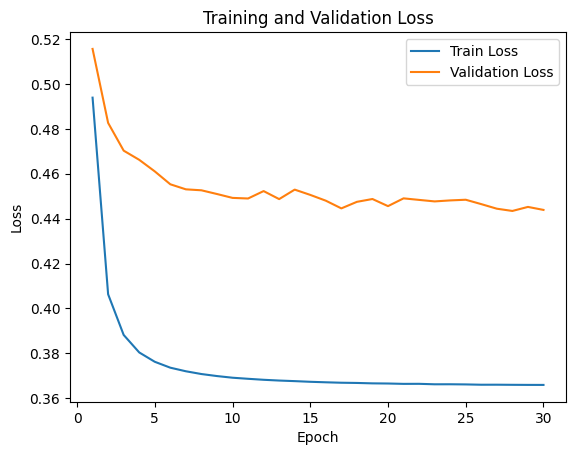

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# === 1. collate_fn ===
def collate_fn(batch):
    ids = [b['input_ids'] for b in batch]
    # Concatenate the label list into 
    labels = torch.cat([b['label'] for b in batch], dim=0)  # [tensor(0.), tensor(1.)] -> tensor([0., 1.]); shape: (batch, 1)
    # Padding based on sequence with the maximum length in the current batch
    padded_ids = pad_sequence(ids, batch_first=True, padding_value=0)  # (batch, L)
    return padded_ids, labels

# === 2. Load data ===
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# === 3. Set model, optimizer, and loss ===
device = torch.device('cpu')
model_76 = BoWClassifier(E_tensor).to(device)
optimizer = optim.Adam(model_76.parameters(), lr=1e-3)
loss_fn   = nn.BCEWithLogitsLoss()

# === 4. Training and Evaluation ===
def train(epoch, model, optimizer, loss_fn, train_dl):
    model.train()
    curr_total_loss = 0.0

    for input_ids, labels in train_dl:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device)  # (batch_size,)

        optimizer.zero_grad()
        logits = model(input_ids).squeeze(-1)   # (batch_size,)
        loss = loss_fn(logits, labels)  # (batch_size,)
        loss.backward()
        optimizer.step()

        curr_total_loss += loss.item()

    train_loss = curr_total_loss / len(train_dl)
    return train_loss

def eval(epoch, model, loss_fn, valid_dl):
    model.eval()
    curr_total_val_loss = 0.0
    with torch.no_grad():
        for input_ids, labels in valid_dl:
            input_ids = input_ids.to(device)    # (batch_size, L)
            labels = labels.to(device).squeeze(-1)  # (batch_size,)
            
            logits = model(input_ids).squeeze(-1)
            curr_total_val_loss += loss_fn(logits, labels).item()

        valid_loss = curr_total_val_loss / len(valid_dl)
    return valid_loss

epochs = 30
train_losses, valid_losses = [], []
for epoch in range(1, epochs + 1):
    train_losses.append(train(epoch, model_76, optimizer, loss_fn, train_loader))
    valid_losses.append(eval(epoch, model_76, loss_fn, valid_loader))
    if epoch % 5 == 0:
        print(f"Epoch {epoch} training loss: {train_losses[-1]:.4f}")
        print(f"Epoch {epoch} validation loss: {valid_losses[-1]:.4f}\n")

# === 5. Plot ===
x = list(range(1, len(train_losses) + 1))
plt.figure()
plt.plot(x, train_losses, label='Train Loss')
plt.plot(x, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [107]:
model_76.eval()
curr_correct, total = 0, 0

with torch.no_grad():
    for input_ids, labels in valid_loader:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device)  # (batch_size,)
        
        logits = model_76(input_ids).squeeze(-1)

        preds = (torch.sigmoid(logits) > 0.5).long()
        curr_correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"validation loss: {valid_loss:.4f}, accuracy: {accuracy * 100:.2f}%")


validation loss: 0.4462, accuracy: 83.49%


## 77. GPU上での学習
問題76のモデル学習をGPU上で実行せよ。また、学習したモデルの開発セットにおける正解率を求めよ。

Epoch 5 training loss: 0.3764
Epoch 5 validation loss: 0.4578

Epoch 10 training loss: 0.3692
Epoch 10 validation loss: 0.4485

Epoch 15 training loss: 0.3673
Epoch 15 validation loss: 0.4513

Epoch 20 training loss: 0.3666
Epoch 20 validation loss: 0.4491

Epoch 25 training loss: 0.3662
Epoch 25 validation loss: 0.4463

Epoch 30 training loss: 0.3659
Epoch 30 validation loss: 0.4497



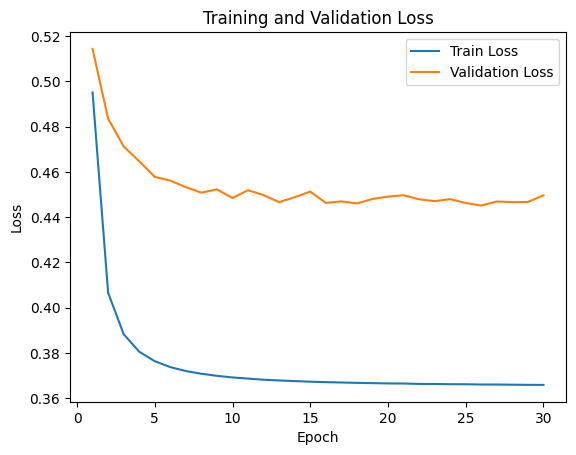

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# === 1. collate_fn ===
def collate_fn(batch):
    ids = [b['input_ids'] for b in batch]
    # Concatenate the label list into 
    labels = torch.cat([b['label'] for b in batch], dim=0)  # [tensor(0.), tensor(1.)] -> tensor([0., 1.]); shape: (batch, 1)
    # Padding based on sequence with the maximum length in the current batch
    padded_ids = pad_sequence(ids, batch_first=True, padding_value=0)  # (batch, L)
    return padded_ids, labels

# === 2. Load data ===
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# === 3. Set model, optimizer, and loss ===
device = torch.device('cuda')
model_77 = BoWClassifier(E_tensor).to(device)
optimizer = optim.Adam(model_77.fc.parameters(), lr=1e-3)
loss_fn   = nn.BCEWithLogitsLoss()

# === 4. Training and Evaluation ===
def train(epoch, model, optimizer, loss_fn, train_dl):
    model.train()
    curr_total_loss = 0.0

    for input_ids, labels in train_dl:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device)  # (batch_size,)

        optimizer.zero_grad()
        logits = model(input_ids).squeeze(-1)   # (batch_size,)
        loss = loss_fn(logits, labels)  # (batch_size,)
        loss.backward()
        optimizer.step()

        curr_total_loss += loss.item()

    train_loss = curr_total_loss / len(train_dl)
    return train_loss

def eval(epoch, model, loss_fn, valid_dl):
    model.eval()
    curr_total_val_loss = 0.0
    with torch.no_grad():
        for input_ids, labels in valid_dl:
            input_ids = input_ids.to(device)    # (batch_size, L)
            labels = labels.to(device)  # (batch_size,)
            
            logits = model(input_ids).squeeze(-1)
            curr_total_val_loss += loss_fn(logits, labels).item()

        valid_loss = curr_total_val_loss / len(valid_dl)
    return valid_loss

epochs = 30
train_losses, valid_losses = [], []
for epoch in range(1, epochs + 1):
    train_losses.append(train(epoch, model_77, optimizer, loss_fn, train_loader))
    valid_losses.append(eval(epoch, model_77, loss_fn, valid_loader))
    if epoch % 5 == 0:
        print(f"Epoch {epoch} training loss: {train_losses[-1]:.4f}")
        print(f"Epoch {epoch} validation loss: {valid_losses[-1]:.4f}\n")

# === 5. Plot ===
x = list(range(1, len(train_losses) + 1))
plt.figure()
plt.plot(x, train_losses, label='Train Loss')
plt.plot(x, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [110]:
model_77.eval()
curr_correct, total = 0, 0

with torch.no_grad():
    for input_ids, labels in valid_loader:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device)  # (batch_size,)
        
        logits = model_77(input_ids).squeeze(-1)

        preds = (torch.sigmoid(logits) > 0.5).long()
        curr_correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"validation loss: {valid_loss:.4f}, accuracy: {accuracy * 100:.2f}%")

    


validation loss: 0.4462, accuracy: 83.49%


## 78. 単語埋め込みのファインチューニング
問題77の学習において、単語埋め込みのパラメータも同時に更新するファインチューニングを導入せよ。また、学習したモデルの開発セットにおける正解率を求めよ。

In [111]:
model_78 = model_77
model_78.embedding.weight.requires_grad = True
optimizer = optim.Adam(model_78.parameters(), lr=1e-4)

Fine-tuning epoch 1 training loss: 0.2499
Fine-tuning epoch 1 validation loss: 0.4074

Fine-tuning epoch 2 training loss: 0.2220
Fine-tuning epoch 2 validation loss: 0.4155



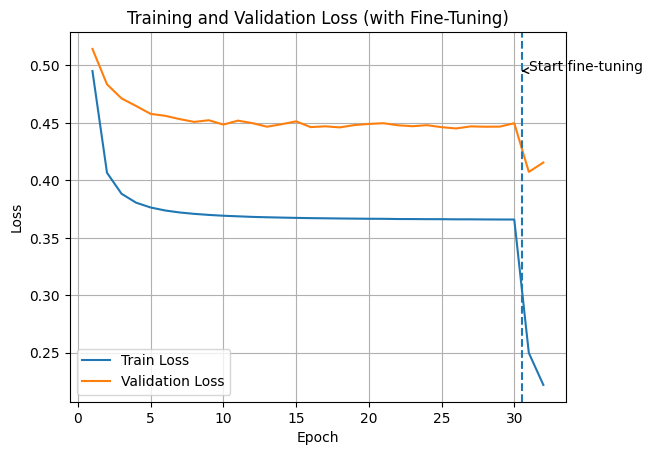

In [113]:
epochs = 2
ft_train_losses, ft_valid_losses = [], []
for epoch in range(1, epochs + 1):
    ft_train_losses.append(train(epoch, model_78, optimizer, loss_fn, train_loader))
    ft_valid_losses.append(eval(epoch, model_78, loss_fn, valid_loader))
    print(f"Fine-tuning epoch {epoch} training loss: {ft_train_losses[-1]:.4f}")
    print(f"Fine-tuning epoch {epoch} validation loss: {ft_valid_losses[-1]:.4f}\n")

# === 5. Plot ===
orig_len = len(train_losses)

all_train = train_losses + ft_train_losses
all_valid = valid_losses + ft_valid_losses

x = list(range(1, len(all_train) + 1))

plt.figure()
plt.plot(x, all_train, label='Train Loss')
plt.plot(x, all_valid, label='Validation Loss')

# Point out the specific epoch in which model has been fine-tuned
plt.axvline(orig_len + 0.5, linestyle='--')
plt.annotate(
    'Start fine-tuning',
    xy=(orig_len + 0.5, max(all_train)),
    xytext=(orig_len + 1, max(all_train)),
    arrowprops=dict(arrowstyle='->')
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (with Fine-Tuning)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model_78.eval()
curr_correct, total = 0, 0

with torch.no_grad():
    for input_ids, labels in valid_loader:
        input_ids = input_ids.to(device)    # (batch_size, L)
        labels = labels.to(device)  # (batch_size,)
        
        logits = model_78(input_ids).squeeze(-1)

        preds = (torch.sigmoid(logits) > 0.5).long()
        curr_correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"validation loss: {valid_loss:.4f}, accuracy: {accuracy * 100:.2f}%")

## 79. アーキテクチャの変更
ニューラルネットワークのアーキテクチャを自由に変更し、モデルを学習せよ。また、学習したモデルの開発セットにおける正解率を求めよ。例えば、テキストの特徴ベクトル（単語埋め込みの平均ベクトル）に対して多層のニューラルネットワークを通したり、畳み込みニューラルネットワーク（CNN; Convolutional Neural Network）や再帰型ニューラルネットワーク（RNN; Recurrent Neural Network）などのモデルの学習に挑戦するとよい。

In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# === 1. collate_fn for RNN ===
def collate_fn(batch):
    batch_sorted = sorted(batch, key=lambda x: x['input_ids'].size(0), reverse=True)
    ids = [b['input_ids'] for b in batch_sorted]
    lengths = torch.tensor([len(seq) for seq in ids], dtype=torch.long)
    padded_ids = pad_sequence(ids, batch_first=True, padding_value=0)
    labels = torch.cat([b['label'] for b in batch_sorted], dim=0)
    return padded_ids, lengths, labels

# === 2. RNN-based classifier with random embeddings ===
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 300,
                 hidden_size: int = 256, num_layers: int = 1,
                 bidirectional: bool = True, dropout: float = 0.5):
        super().__init__()
        # Randomly initialized embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # LSTM encoder
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * factor, 1)

    def forward(self, input_ids: torch.LongTensor, lengths: torch.LongTensor):
        emb = self.embedding(input_ids)  # (batch, seq_len, emb_dim)
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, (hn, cn) = self.rnn(packed)
        if self.rnn.bidirectional:
            last_h = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            last_h = hn[-1]
        logits = self.fc(last_h).squeeze(-1)
        return logits

# === 3. DataLoader setup ===
vocab_size = len(token2id)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False, collate_fn=collate_fn)

# === 4. Training and evaluation ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNNClassifier(vocab_size=vocab_size, emb_dim=300,
                      hidden_size=256, num_layers=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 3
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss = 0.0
    for input_ids, lengths, labels in train_loader:
        input_ids = input_ids.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device).squeeze(-1)

        optimizer.zero_grad()
        logits = model(input_ids, lengths)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for input_ids, lengths, labels in valid_loader:
            input_ids = input_ids.to(device)
            lengths = lengths.to(device)
            labels = labels.to(device).squeeze(-1)

            logits = model(input_ids, lengths)
            total_val_loss += loss_fn(logits, labels).item()
            preds = (torch.sigmoid(logits) > 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(valid_loader)
    accuracy = correct / total
    print(f"Epoch {epoch:02d} | train loss: {avg_train_loss:.4f} "
          f"| val loss: {avg_val_loss:.4f} | val acc: {accuracy:.4f}")


Epoch 01 | train loss: 0.3680 | val loss: 0.5067 | val acc: 0.7683
Epoch 02 | train loss: 0.1639 | val loss: 0.5006 | val acc: 0.8028
Epoch 03 | train loss: 0.0951 | val loss: 0.5381 | val acc: 0.8062
